In [128]:
! pip install folium
! pip install geopy
! pip install geocoder
! pip install haversine
! pip install beautifulsoup4
! pip install lxml
! sudo apt install python3-lxml

## ! pip install pgeocode
## ! pip install reverse-geocode
## ! pip install pgeocode

/bin/bash: sudo: command not found
Notebook already signed: Toronto_AutoTheft.ipynb


In [194]:
! jupyter trust Toronto_AutoTheft.ipynb

Notebook already signed: Toronto_AutoTheft.ipynb


# 1. Problem: Find a top rated stakehouse in a low crime neighbourhood in central Toronto
#### I will be staying in central Toronto for one night and would like to eat at a top rated steakhouse restaurant. I will be driving and so I would like to ensure that I select a restaurant in an area with the least amount of car thefts.

##### 2. Data sources:
<li> Wikipedia's postal codes for Toronto: to identify central Toronto.</li>
<li> Geocoder: pass postal codes and get geocodes.</li>
<li> Foursquare: pass geocodes and return top rated venues.</li>
<li> Toronto Police Car Theft data: merge with central Toronto to find venue with least crime.</li>    

##### Steps:
<ol>
<li>Import Toronto postal codes (webscraped from WIKI)</li>
<li>Download corresponding geocodes</li>
<li>Merge geocodes with postal codes</li>
<li>Filter only boroughs containing Toronto & graph map</li>
<li>Use foursquare to retrive top venues by postal code</li>    
<ol>
<li>Build dataframe by category</li>
<li>Filter for stakehouses</li>
</ol>
<li>Read in car theft data</li>
<li>Merge stakehouses and car theft dataframes</li>
<li>Calculating distance in KM between stakehouses and car theft locations</li>
<li>Filter for car thefts within a half KM around restaurant locations</li>
<li>Aggregate total car thefts by stakehouse and select the lowest one</li>
<li>Map the car theft locations around the preferred steakhouse</li>
<li>Now get dressed up, hop in car and enjoy a nice dinner!!!</li>
</ol>

In [129]:
# Importing standard libraires
import pandas as pd
import numpy as np

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

## 1. Reading postal codes by Toronto borough

In [130]:
# Importing libraries
import requests
from bs4 import BeautifulSoup

# Making request and parsing 
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
wiki = requests.get(url).text
# soup = BeautifulSoup(wiki, 'lxml')
soup = BeautifulSoup(wiki, "html.parser")


#####Finding table header and data

In [131]:
table = soup.find("table", attrs={"class": "wikitable sortable"})
header_data = table.tbody.find_all("tr")[0]
table_data = table.tbody.find_all("td")
postcode=[]
borough=[]
neighbourhood=[]
headings = []

##### Get all the headings of Lists

In [132]:
for td in header_data.find_all("th"):

    # remove any newlines and extra spaces from left and right
    headings.append(td.text.replace('\n', ' ').strip().replace(' ', '_'))

print(headings)

['Postal_Code', 'Borough', 'Neighbourhood']


##### Looping on table data and appending to lists.
###### Skip every 3 rows as all 3 columns of data are in one column

In [133]:
for k in range(0,540,3):
    postcode.append(table_data[k].text.replace('\n', '').strip())
    borough.append(table_data[k+1].text.replace('\n', '').strip())
    neighbourhood.append(table_data[k+2].text.replace('\n', '').strip())

##### Creating dataframe and dropping cases where Boroughs are unassigned

In [134]:
df_poscode = pd.DataFrame(zip(postcode,borough,neighbourhood),columns=headings)
df_poscode = df_poscode[df_poscode.Borough!='Not assigned'].reset_index(drop=True)
df_poscode.head()

,Postal_Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [135]:
df_poscode['Borough'].value_counts()

North York          24
Downtown Toronto    19
Scarborough         17
Etobicoke           12
Central Toronto      9
West Toronto         6
York                 5
East York            5
East Toronto         5
Mississauga          1
Name: Borough, dtype: int64

In [136]:
# Check to make sure postal codes are Unique
print("Postal codes are unique:",df_poscode.Postal_Code.is_unique)

Postal codes are unique: True


In [137]:
# Check that all Neighborhoods are Assigned
df_poscode[df_poscode.Neighbourhood=='Not assigned']

,Postal_Code,Borough,Neighbourhood


In [138]:
df_poscode.head()

,Postal_Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


## 2. Downloading Geocodes

In [139]:
import geocoder

lats=[]
longs=[]
for i in df_poscode['Postal_Code']:
    lat_lng_coords=None
    while(lat_lng_coords is None):
        g=geocoder.arcgis('{}, Toronto, Ontario'.format(i))
        lat_lng_coords=g.latlng
    latitude=lat_lng_coords[0]
    longitude=lat_lng_coords[1]
    lats.append(latitude)
    longs.append(longitude)

df_geo = pd.concat([df_poscode['Postal_Code'],pd.DataFrame(lats,columns=['Latitude']),pd.DataFrame(longs,columns=['Longitude'])],axis=1)

In [142]:
# df_geo = pd.read_csv('toronto_geocodes.csv')
df_geo.head()

,Postal_Code,Latitude,Longitude
0,M3A,43.75245,-79.32991
1,M4A,43.73057,-79.31306
2,M5A,43.65512,-79.36264
3,M6A,43.72327,-79.45042
4,M7A,43.66253,-79.39188


## 3. Merging the Latitude & Longitude data in to original dataframe

In [143]:
df_poscode = pd.merge(df_poscode,df_geo,left_on='Postal_Code', right_on='Postal_Code',suffixes=(None,None))

In [144]:
df_poscode.head()

,Postal_Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.75245,-79.32991
1,M4A,North York,Victoria Village,43.73057,-79.31306
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65512,-79.36264
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.72327,-79.45042
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.66253,-79.39188


## 4. Boroughs containing only Toronto and creating map

In [145]:
df_toronto = df_poscode[df_poscode['Borough'].str.contains('Toronto')].reset_index(drop=True)

In [146]:
df_toronto['Borough'].unique()  # 4 boroughs in toronto

array(['Downtown Toronto', 'East Toronto', 'West Toronto',
       'Central Toronto'], dtype=object)

In [147]:
len(df_toronto['Neighbourhood'].unique())

39

In [148]:
# from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# address = 'Toronto, Ontario'
# geolocator = Nominatim(user_agent="toronto_explorer")
# location = geolocator.geocode(address)
# latitude = location.latitude
# longitude = location.longitude
# print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))
latTOR =  43.677805
lngTOR = -79.402190

In [149]:
import folium # map rendering library
map_toronto = folium.Map(location=[latTOR, lngTOR], zoom_start=12.5)

# add markers to map
for lat, lng, label in zip(df_toronto['Latitude'], df_toronto['Longitude'], df_toronto['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

## 5. Getting top 100 venues around the four Toronto boroughs

In [150]:
## Function will return latitude/longitudes for up to 100 venues in a 500 radius for given postal code

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

def topvenues(postal_code,neighborhood_latitude,neighborhood_longitude):
    
    # Define Foursquare Credentials and Version
    CLIENT_ID = 'NI5DU0DH0ZB32IY0VLGVYQUHZCDAFXSL1ARMWPCR12EJYQTD' # your Foursquare ID
    CLIENT_SECRET = 'X041FK0ACUA0YVYFVLBYJMMKKGGZPCNA3N2ML05VMSZTLIZH' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    LIMIT = 100 # A default Foursquare API limit value

     # create URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
    
    req = requests.get(url).json()
    req = req['response']['groups'][0]['items']
    
    # flatten JSON
    nearby_venues = pd.json_normalize(req)
    
    # filter columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.postalCode', 
                        'venue.location.lat', 'venue.location.lng']
    nearby_venues = nearby_venues.loc[:, filtered_columns]
    
    # function that extracts the category of the venue
    def get_category_type(req):
        try:
            categories_list = req['categories']
        except:
            categories_list = req['venue.categories']

        if len(categories_list) == 0:
            return None
        else:
            return categories_list[0]['name']
        
    # filter the category for each row
    nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
    
    # adjust postal code to 3 digit
    nearby_venues.columns = ['Name','Categories','PostalCode','Latitude','Longitude']
    nearby_venues['PostalCode3'] = postal_code
    results = nearby_venues[['Name','Categories','PostalCode','PostalCode3','Latitude','Longitude']]
    
    return results    

## 5.1. Building dataframe for all venues by category

In [151]:
df_venue = pd.DataFrame()
for pcde in df_toronto.Postal_Code.unique():   
    try:       
        cond = df_toronto[df_toronto.Postal_Code==pcde]
        lat = cond['Latitude'].values[0]
        lng = cond['Longitude'].values[0]
        tpven = topvenues(pcde,lat,lng)
        df_venue = pd.concat([df_venue, tpven],axis=0)
        #print(tpven)
 #       print('Latitude & Longitude are: {} & {}'.format(lat,lng))
    except:
        print('No venues for postal code: {}'.format(pcde))

No venues for postal code: M4N
No venues for postal code: M4R


In [152]:
# df_venue = pd.read_csv('toronto_venues.csv')
df_venue.columns=['Name', 'Categories', 'PostalCode', 'PostalCode3', 'RestLat','RestLon']

In [153]:
df_venue.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1709 entries, 0 to 99
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         1709 non-null   object 
 1   Categories   1709 non-null   object 
 2   PostalCode   1342 non-null   object 
 3   PostalCode3  1709 non-null   object 
 4   RestLat      1709 non-null   float64
 5   RestLon      1709 non-null   float64
dtypes: float64(2), object(4)
memory usage: 93.5+ KB


## 5.2. Filtering for top steakhouses

In [154]:
df_venue = df_venue[df_venue['Categories']=='Steakhouse'].drop_duplicates(['Name']).reset_index(drop=True)

##### Correcting postal code.
* Taking 3 digits from venue postal code if available
* Otherwise will take 3 digit from borough location


In [155]:
df_venue['Postal_Code'] = np.where(df_venue['PostalCode'].isna()==True,
                                                       df_venue['PostalCode3'],
                                                       df_venue['PostalCode'].str[:3])
df_venue.drop(['PostalCode','PostalCode3'],inplace=True, axis=1)  
df_venue = df_venue[['Name','Categories','Postal_Code','RestLat','RestLon']]

In [156]:
df_venue

,Name,Categories,Postal_Code,RestLat,RestLon
0,Barberian's Steak House,Steakhouse,M5G,43.657755,-79.382177
1,Hy's Steakhouse,Steakhouse,M5H,43.649505,-79.382919
2,Ruth's Chris Steak House,Steakhouse,M5H,43.649917,-79.385724
3,Michael's on Simcoe,Steakhouse,M5H,43.648269,-79.386328
4,Harbour 60 Toronto,Steakhouse,M5J,43.642220,-79.377945
5,The Tulip Steakhouse,Steakhouse,M4L,43.666348,-79.316854
6,The Keg Steakhouse + Bar,Steakhouse,M4Y,43.666756,-79.378302


## 6. Read in car theft data

##### The Auto Theft dataset is a subset of the Major Crime Indicators (MCI), covering car thefts reported from 2014 to 2019 in Toronto by location.
##### The data has been made publicly available by the Toronto Police Service. 
##### The locations are deliberate approximations of the nearest intersection to where the incident occurred.

In [182]:
df_car = pd.read_csv('Toronto_Auto_Theft_2014_to_2019.csv')

In [183]:
df_car.head(2)

,X,Y,Index_,event_unique_id,occurrencedate,reporteddate,premisetype,ucr_code,ucr_ext,offence,...,occurrencedayofyear,occurrencedayofweek,occurrencehour,MCI,Division,Hood_ID,Neighbourhood,Lat,Long,ObjectId
0,-8.858137e+06,5.428285e+06,58170,GO-20141673399,2014/03/09 05:00:00+00,2014/03/10 04:00:00+00,House,2135,210,Theft Of Motor Vehicle,...,68.0,Sunday,17,Auto Theft,D31,21,Humber Summit (21),43.759407,-79.574,1
1,-8.851792e+06,5.427584e+06,58171,GO-20142467943,2014/07/10 04:00:00+00,2014/07/10 04:00:00+00,Outside,2135,210,Theft Of Motor Vehicle,...,191.0,Thursday,9,Auto Theft,D31,25,Glenfield-Jane Heights (25),43.754856,-79.517,2


##### Selecting only geo codes and getting unique counts

In [184]:
df_car=df_car[['Lat','Long']].value_counts().to_frame().reset_index()

In [185]:
df_car.columns = ['CarLat','CarLon','TheftCount']

In [186]:
df_car.head()

,CarLat,CarLon,TheftCount
0,43.710690,-79.611,161
1,43.718128,-79.599,108
2,43.773617,-79.261,98
3,43.686760,-79.596,94
4,43.781639,-79.416,82


In [187]:
df_car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9016 entries, 0 to 9015
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CarLat      9016 non-null   float64
 1   CarLon      9016 non-null   float64
 2   TheftCount  9016 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 211.4 KB


## 7. Now merging stakehouses and car theft data

In [163]:
df_venue_thefts = pd.DataFrame()
for j in range(0,7):
    tmp = pd.concat([df_venue.loc[j].to_frame().transpose()]*len(df_car), ignore_index=True).join(df_car)
    df_venue_thefts = pd.concat([df_venue_thefts, tmp],axis=0)

In [164]:
df_venue_thefts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63112 entries, 0 to 9015
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         63112 non-null  object 
 1   Categories   63112 non-null  object 
 2   Postal_Code  63112 non-null  object 
 3   RestLat      63112 non-null  object 
 4   RestLon      63112 non-null  object 
 5   CarLat       63112 non-null  float64
 6   CarLon       63112 non-null  float64
 7   TheftCount   63112 non-null  int64  
dtypes: float64(2), int64(1), object(5)
memory usage: 4.3+ MB


In [165]:
df_venue_thefts.groupby(['Name']).count()

,Categories,Postal_Code,RestLat,RestLon,CarLat,CarLon,TheftCount
Name,,,,,,,
Barberian's Steak House,9016,9016,9016,9016,9016,9016,9016
Harbour 60 Toronto,9016,9016,9016,9016,9016,9016,9016
Hy's Steakhouse,9016,9016,9016,9016,9016,9016,9016
Michael's on Simcoe,9016,9016,9016,9016,9016,9016,9016
Ruth's Chris Steak House,9016,9016,9016,9016,9016,9016,9016
The Keg Steakhouse + Bar,9016,9016,9016,9016,9016,9016,9016
The Tulip Steakhouse,9016,9016,9016,9016,9016,9016,9016


##### Correct data type

In [166]:
df_venue_thefts[["RestLat", "RestLon"]] = df_venue_thefts[["RestLat", "RestLon"]].apply(pd.to_numeric)

In [167]:
df_venue_thefts[["RestLat", "RestLon"]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63112 entries, 0 to 9015
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   RestLat  63112 non-null  float64
 1   RestLon  63112 non-null  float64
dtypes: float64(2)
memory usage: 1.4 MB


In [168]:
df_venue_thefts.head()

,Name,Categories,Postal_Code,RestLat,RestLon,CarLat,CarLon,TheftCount
0,Barberian's Steak House,Steakhouse,M5G,43.657755,-79.382177,43.710690,-79.611,161
1,Barberian's Steak House,Steakhouse,M5G,43.657755,-79.382177,43.718128,-79.599,108
2,Barberian's Steak House,Steakhouse,M5G,43.657755,-79.382177,43.773617,-79.261,98
3,Barberian's Steak House,Steakhouse,M5G,43.657755,-79.382177,43.686760,-79.596,94
4,Barberian's Steak House,Steakhouse,M5G,43.657755,-79.382177,43.781639,-79.416,82


## 8. Calculating distance in KM between stakehouses and crime locations

##### Will use the the Haversine formula to find distance between two points
##### The Haversine formula calculates the shortest distance between two points on a sphere using their latitudes and longitudes measured along the surface.

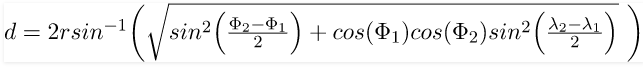

In [169]:
import numpy as np

def haversine_vectorize(lon1, lat1, lon2, lat2):

    # convert to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # calculate difference
    newlon = lon2 - lon1
    newlat = lat2 - lat1

    # apply haversine formula
    haver_formula = np.sin(newlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(newlon/2.0)**2

    dist = 2 * np.arcsin(np.sqrt(haver_formula))
    km = 6367 * dist #6367 for distance in KM for miles use 3958
    return km

In [170]:
df_venue_thefts['DistKM'] = haversine_vectorize(df_venue_thefts['RestLon'],df_venue_thefts['RestLat'],
                                                df_venue_thefts['CarLon'],df_venue_thefts['CarLat'])

In [171]:
df_venue_thefts.head()

,Name,Categories,Postal_Code,RestLat,RestLon,CarLat,CarLon,TheftCount,DistKM
0,Barberian's Steak House,Steakhouse,M5G,43.657755,-79.382177,43.710690,-79.611,161,19.306341
1,Barberian's Steak House,Steakhouse,M5G,43.657755,-79.382177,43.718128,-79.599,108,18.670041
2,Barberian's Steak House,Steakhouse,M5G,43.657755,-79.382177,43.773617,-79.261,98,16.139918
3,Barberian's Steak House,Steakhouse,M5G,43.657755,-79.382177,43.686760,-79.596,94,17.486032
4,Barberian's Steak House,Steakhouse,M5G,43.657755,-79.382177,43.781639,-79.416,82,14.032059


## 9. Filter for crimes within a half KM around restaurant locations

In [172]:
df_venue_thefts = df_venue_thefts[df_venue_thefts['DistKM']<=0.5]

In [180]:
df_venue_thefts.head()

,Name,Categories,Postal_Code,RestLat,RestLon,CarLat,CarLon,TheftCount,DistKM
111,Barberian's Steak House,Steakhouse,M5G,43.657755,-79.382177,43.656265,-79.378,17,0.374442
176,Barberian's Steak House,Steakhouse,M5G,43.657755,-79.382177,43.654064,-79.380,12,0.445952
275,Barberian's Steak House,Steakhouse,M5G,43.657755,-79.382177,43.656502,-79.377,9,0.438932
404,Barberian's Steak House,Steakhouse,M5G,43.657755,-79.382177,43.661373,-79.383,8,0.407450
598,Barberian's Steak House,Steakhouse,M5G,43.657755,-79.382177,43.657311,-79.384,6,0.154636


In [174]:
print('There are {} locations where vehicle thefts have occurred near a stakehouse'.format(len(df_venue_thefts)))

There are 212 locations where vehicle thefts have occurred near a stakehouse


## 10. Aggregate total vehicle thefts by stakehouse and select the restaurant with the lowest number of thefts

In [175]:
df_venue_thefts['TheftCount'] = df_venue_thefts['TheftCount'].astype(int)

In [176]:
df_venue_thefts_agg = df_venue_thefts[['Name','TheftCount']].groupby('Name').sum().sort_values(by='TheftCount').reset_index()

In [177]:
df_venue_thefts_agg.head(7)

,Name,TheftCount
0,The Tulip Steakhouse,33
1,Harbour 60 Toronto,53
2,Ruth's Chris Steak House,67
3,Hy's Steakhouse,71
4,Michael's on Simcoe,85
5,The Keg Steakhouse + Bar,98
6,Barberian's Steak House,138


In [178]:
best_rest_nm = df_venue_thefts_agg['Name'][0]

crime_loc = df_venue_thefts.loc[df_venue_thefts['Name']==best_rest_nm,['CarLat','CarLon']]
crime_label = 'Car thefts=' + df_venue_thefts.loc[df_venue_thefts['Name']==best_rest_nm,['TheftCount']].astype(str)
best_rest_loc = df_venue_thefts.loc[df_venue_thefts['Name']==best_rest_nm,['RestLat','RestLon']].drop_duplicates()
best_rest_lat = best_rest_loc.iloc[0]['RestLat']
best_rest_lon = best_rest_loc.iloc[0]['RestLon']

best_rest_ct = df_venue_thefts_agg['TheftCount'][0]
locations = crime_loc[['CarLat','CarLon']]
locationlist = locations.values.tolist()
print('The best steakhouse with the lowest number of car thefts is: {}.\nThere were a total of {} car thefts in a half KM radius around The Tulip.\nSpanning {} locations in Toronto, reported over the past five years.'.format(best_rest_nm,best_rest_ct,len(crime_loc)))

The best steakhouse with the lowest number of car thefts is: The Tulip Steakhouse.
There were a total of 33 car thefts in a half KM radius around The Tulip.
Spanning 21 locations in Toronto, reported over the past five years.


## 11. Finally, mapping the car theft locations around the preferred steakhouse

In [179]:
import folium # map rendering library
from folium.plugins import MarkerCluster
latTOR = 43.667623
lngTOR = -79.315034

map_toronto = folium.Map(location=[latTOR, lngTOR], zoom_start=15)

# add restaurant location to map
label = folium.Popup(best_rest_nm, parse_html=True)
folium.CircleMarker(
    [best_rest_lat, best_rest_lon],
    radius=8,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_toronto)

marker_cluster = MarkerCluster().add_to(map_toronto)

for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point], popup=crime_label.iloc[point]['TheftCount']).add_to(marker_cluster)
map_toronto

In [76]:
# def getpostalcode(lat,lng):

#     import requests
#     url = "https://trueway-geocoding.p.rapidapi.com/ReverseGeocode"
#     querystring = {"location":"{},{}".format(lat,lng),"language":"en"} #43.759407, -79.574

#     headers = {
#         'x-rapidapi-key': "e20b2beb70msh2336e9e84a7d507p1d76edjsnda579985c290",
#         'x-rapidapi-host': "trueway-geocoding.p.rapidapi.com"
#             }

#     response = requests.request("GET", url, headers=headers, params=querystring)
#     req = response.json()
#     req1 = req['results'][0]
#     result = pd.json_normalize(req1)

#     return result

In [66]:
#1454

In [68]:
# df_car1 = df_car.iloc[1454:]

In [109]:
# df_car1.head()

In [110]:
# import time
# df_latlng = pd.DataFrame()
# n = len(df_car1)
# m = 0
# z = 0
# for i,row in df_car1.iterrows():
#     print(row)
#     m+=1
#     z+=1
#     print('Downloading.....'
#           '{} of {}'.format(m,n))
#     x = row[['Lat','Long']].values
#     lat = x[0]
#     lng = x[1]
#     df_tmp = getpostalcode(lat,lng)
#     df_latlng = pd.concat([df_latlng,df_tmp],axis=0)
#     if z==2:
#         time.sleep(2)
#         z=0

In [ ]:
# # Define functions to download as CSV or Excel
# from IPython.display import HTML
# import pandas as pd
# import base64, io

# # Download as CSV: data frame, optional title and filename
# def create_download_link_csv(df, title = "Download CSV file", filename = "data.csv"):  
#     # generate in-memory CSV, then base64-encode it
#     csv = df.to_csv(index=False)
#     b64 = base64.b64encode(csv.encode())
#     payload = b64.decode()
#     html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
#     html = html.format(payload=payload,title=title,filename=filename)
#     return HTML(html)

# create_download_link_csv(df_geo,"Download my data","toronto_geocodes.csv")
# create_download_link_csv(df_venue,"Download my data","toronto_venues.csv")